<a href="https://colab.research.google.com/github/Mjauu/text-mining/blob/master/sentiment-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text Mining
Zbiór Danych: sentyment_movies.csv zawiera recenzję filmów z portalu branżowego, wraz ze zmienną zawierającą informację, czy recenzja jest pozytywna, czy negatywna.

- Wskaż, które słowa są najbardziej charakterystyczne dla recenzji pozytywnych, a które dla negatywnych. - OK
- Pamiętaj o filtrowaniu słów stanowiących szum, oraz o wybieraniu tych kategorii słów, które mogą być adekwatne do zadania. - OK
- Za pomocą znanych Ci metod uczenia maszynowego sprawdź, czy istnieją jakieś zgrupowania współwystępujących ze sobą słów.

- https://www.kaggle.com/oumaimahourrane/sentiment-analysis-ml-models-comparison
- https://www.kaggle.com/oumaimahourrane/imdb-reviews/kernels
- https://www.kaggle.com/sergiadi/iet-x-mlda-workshop
- https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

In [1]:
import re
import nltk
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go

plt.style.use('fivethirtyeight')
py.init_notebook_mode(connected=True)

from nltk.corpus import stopwords
from textblob import TextBlob, Word
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, Perceptron, LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from time import time

nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. Read data

## 1.1 Get from GitHub

In [7]:
# 2 columns
# comma-separated values
# Latin encoding
url = 'https://raw.githubusercontent.com/Mjauu/text-mining/master/sentiment_movies.csv'
data = pd.read_csv(url, encoding='latin-1')
data.head()

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


## 1.2. Describe

In [8]:
data.describe()

,Sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


## 1.3 Check the balance

In [9]:
data['Sentiment'].value_counts()

1    12500
0    12500
Name: Sentiment, dtype: int64

## 1.4 Get sample text

In [10]:
random.sample(data['SentimentText'].values.tolist(), 1)

["chance encounter salesman hit-man changes lives. odd film works, impressive effort writer-director Shepard. daringly unglamorous role far cry James Bond, Brosnan surprisingly effective lonely hit-man starts buckle stress job, unable connect emotionally anyone help cope. Kinnear equally good salesman, decent fellow void life. Davis fine Kinnear's flirtatious wife. Mainly character study, film rewarding feels fresh unpredictable, extremely dark comedy."]

# 2. Find out data properties

## 2.1 Number of words

In [0]:
# Assumption - the negative sentiments contain a lesser amount of words than the positive ones
data['word_count'] = data['SentimentText'].apply(lambda x: len(str(x).split(" ")))
data.head()

,SentimentText,Sentiment,word_count
0,"first think another Disney movie, might good, ...",1,52
1,"Put aside Dr. House repeat missed, Desperate H...",0,86
2,"big fan Stephen King's work, film made even gr...",1,193
3,watched horrid thing TV. Needless say one movi...,0,63
4,truly enjoyed film. acting terrific plot. Jeff...,1,65


## 2.2 Number of characters

In [0]:
# The calculation will also include the number of spaces
data['char_count'] = data['SentimentText'].str.len() ## this also includes spaces
data.head()

,SentimentText,Sentiment,word_count,char_count
0,"first think another Disney movie, might good, ...",1,52,314
1,"Put aside Dr. House repeat missed, Desperate H...",0,86,565
2,"big fan Stephen King's work, film made even gr...",1,193,1268
3,watched horrid thing TV. Needless say one movi...,0,63,414
4,truly enjoyed film. acting terrific plot. Jeff...,1,65,477


## 2.3 Average word length

In [0]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

data['avg_word'] = data['SentimentText'].apply(lambda x: avg_word(x))
data.head()

,SentimentText,Sentiment,word_count,char_count,avg_word
0,"first think another Disney movie, might good, ...",1,52,314,5.057692
1,"Put aside Dr. House repeat missed, Desperate H...",0,86,565,5.581395
2,"big fan Stephen King's work, film made even gr...",1,193,1268,5.575130
3,watched horrid thing TV. Needless say one movi...,0,63,414,5.587302
4,truly enjoyed film. acting terrific plot. Jeff...,1,65,477,6.353846


## 2.4 Number of stopwords

In [0]:
stop = stopwords.words('english')
data['stopwords'] = data['SentimentText'].apply(lambda x: len([x for x in x.split() if x in stop]))
data.head()

,SentimentText,Sentiment,word_count,char_count,avg_word,stopwords
0,"first think another Disney movie, might good, ...",1,52,314,5.057692,1
1,"Put aside Dr. House repeat missed, Desperate H...",0,86,565,5.581395,2
2,"big fan Stephen King's work, film made even gr...",1,193,1268,5.575130,3
3,watched horrid thing TV. Needless say one movi...,0,63,414,5.587302,1
4,truly enjoyed film. acting terrific plot. Jeff...,1,65,477,6.353846,2


## 2.5 Number of numerics

In [0]:
data['numerics'] = data['SentimentText'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data.head()

,SentimentText,Sentiment,word_count,char_count,avg_word,stopwords,numerics
0,"first think another Disney movie, might good, ...",1,52,314,5.057692,1,2
1,"Put aside Dr. House repeat missed, Desperate H...",0,86,565,5.581395,2,4
2,"big fan Stephen King's work, film made even gr...",1,193,1268,5.575130,3,1
3,watched horrid thing TV. Needless say one movi...,0,63,414,5.587302,1,0
4,truly enjoyed film. acting terrific plot. Jeff...,1,65,477,6.353846,2,0


## 2.6 Number of uppercase words

In [0]:
# Anger or rage could be expressed by writing in UPPERCASE
data['upper'] = data['SentimentText'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
data.head()

,SentimentText,Sentiment,word_count,char_count,avg_word,stopwords,numerics,upper
0,"first think another Disney movie, might good, ...",1,52,314,5.057692,1,2,0
1,"Put aside Dr. House repeat missed, Desperate H...",0,86,565,5.581395,2,4,1
2,"big fan Stephen King's work, film made even gr...",1,193,1268,5.575130,3,1,0
3,watched horrid thing TV. Needless say one movi...,0,63,414,5.587302,1,0,2
4,truly enjoyed film. acting terrific plot. Jeff...,1,65,477,6.353846,2,0,0


# 3. Preprocessing

## 3.1 Lower case

In [0]:
data['SentimentText'] = data['SentimentText'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['SentimentText'].head()

0    first think another disney movie, might good, ...
1    put aside dr. house repeat missed, desperate h...
2    big fan stephen king's work, film made even gr...
3    watched horrid thing tv. needless say one movi...
4    truly enjoyed film. acting terrific plot. jeff...
Name: SentimentText, dtype: object

## 3.2 Remove URLs

In [0]:
data['SentimentText'] = data['SentimentText'].apply(lambda x: re.sub(r'(?:\@|https?\://)\S+', '', x))
data['SentimentText'].head()

0    first think another disney movie, might good, ...
1    put aside dr. house repeat missed, desperate h...
2    big fan stephen king's work, film made even gr...
3    watched horrid thing tv. needless say one movi...
4    truly enjoyed film. acting terrific plot. jeff...
Name: SentimentText, dtype: object

## 3.3 Remove html tags

In [0]:
data['SentimentText'] = data['SentimentText'].apply(lambda x: re.sub(r'<[^>]+>', '', x))
data['SentimentText'].head()

0    first think another disney movie, might good, ...
1    put aside dr. house repeat missed, desperate h...
2    big fan stephen king's work, film made even gr...
3    watched horrid thing tv. needless say one movi...
4    truly enjoyed film. acting terrific plot. jeff...
Name: SentimentText, dtype: object

## 3.4 Remove punctuation

In [0]:
data['SentimentText'] = data['SentimentText'].str.replace('[^\w\s]','')
data['SentimentText'].head()

0    first think another disney movie might good it...
1    put aside dr house repeat missed desperate hou...
2    big fan stephen kings work film made even grea...
3    watched horrid thing tv needless say one movie...
4    truly enjoyed film acting terrific plot jeff c...
Name: SentimentText, dtype: object

## 3.5 Remove stop words

In [0]:
data['SentimentText'] = data['SentimentText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['SentimentText'].head()

0    first think another disney movie might good ki...
1    put aside dr house repeat missed desperate hou...
2    big fan stephen kings work film made even grea...
3    watched horrid thing tv needless say one movie...
4    truly enjoyed film acting terrific plot jeff c...
Name: SentimentText, dtype: object

## 3.6 Common words

### 3.6.1 Count common words

In [0]:
freq_common = pd.Series(' '.join(data['SentimentText']).split()).value_counts()[:10]
freq_common

movie     41797
film      37455
one       25147
like      19558
good      14508
even      12325
would     12124
time      11781
really    11636
story     11425
dtype: int64

### 3.6.2 Remove common words

In [0]:
freq_common = list(freq_common.index)
data['SentimentText'] = data['SentimentText'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_common))
data['SentimentText'].head()

0    first think another disney might kids watch ca...
1    put aside dr house repeat missed desperate hou...
2    big fan stephen kings work made greater fan ki...
3    watched horrid thing tv needless say movies wa...
4    truly enjoyed acting terrific plot jeff combs ...
Name: SentimentText, dtype: object

## 3.7 Word cloud

### 3.7.1 Word cloud of negative terms

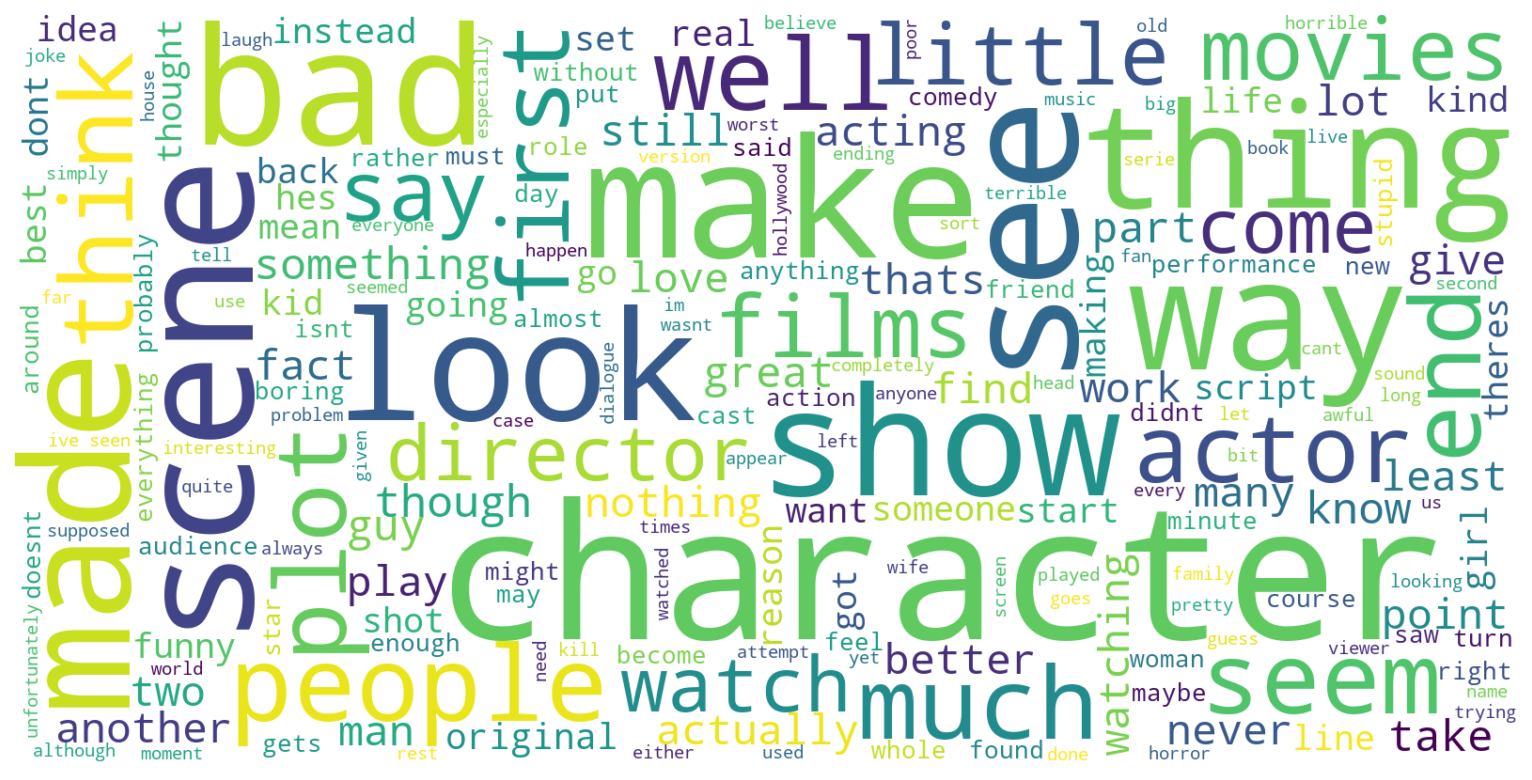

In [0]:
neg_tweets = data[data.Sentiment == 0]
neg_string = []
for t in neg_tweets.SentimentText:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color='white').generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 3.7.1 Word cloud of positive terms

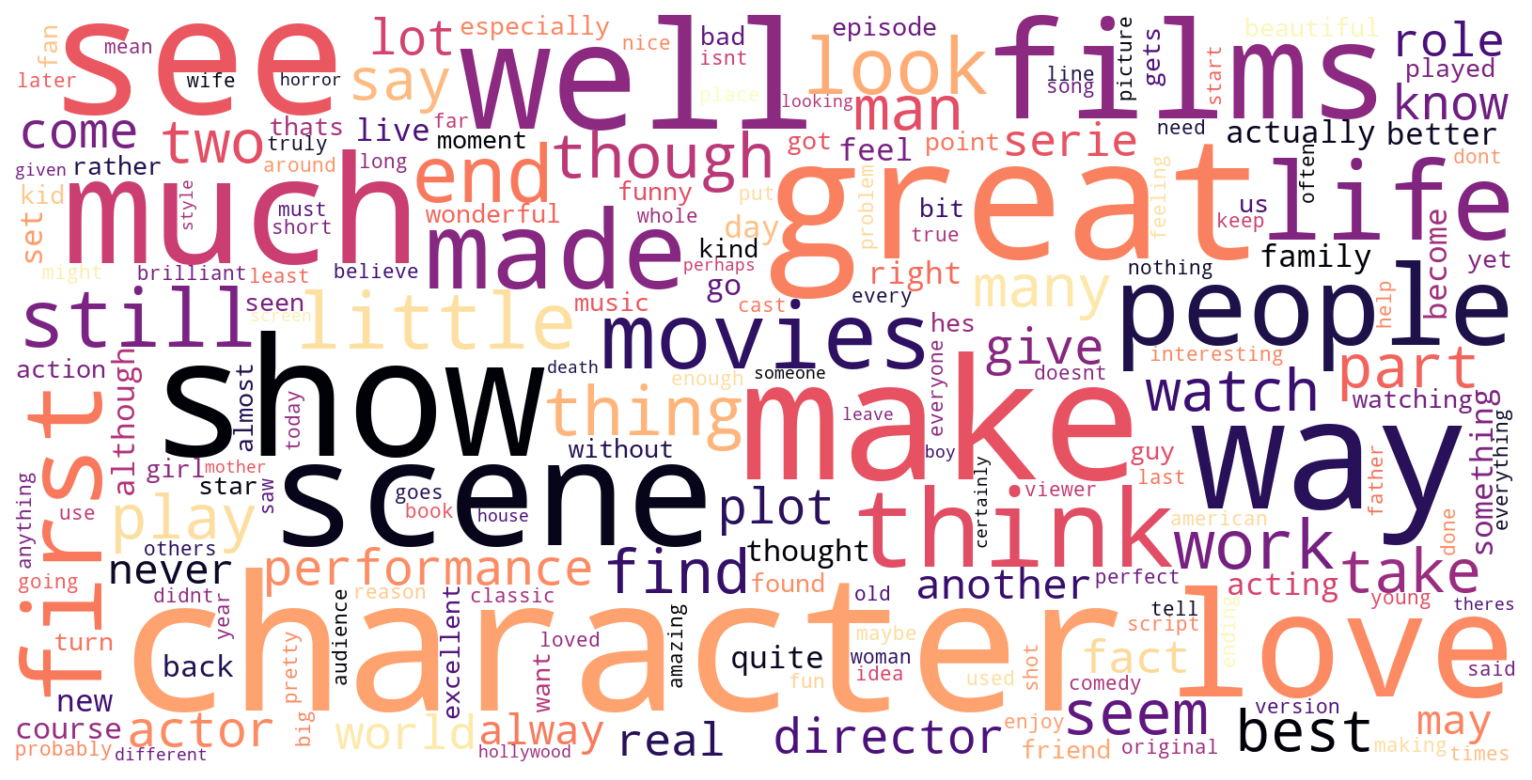

In [0]:
pos_tweets = data[data.Sentiment == 1]
pos_string = []
for t in pos_tweets.SentimentText:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma', background_color='white').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [0]:

test_pos = pos_string[pos_string.isin(neg_string)]
test_neg = neg_string[neg_string.isin(pos_string)]


AttributeError: 'str' object has no attribute 'isin'

In [0]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma', background_color='white').generate(test_pos) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [0]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma', background_color='white').generate(test_neg) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

## 3.7 Rare words

In [0]:
freq_rare = pd.Series(' '.join(data['SentimentText']).split()).value_counts()[-10:]
freq_rare

planetoids           1
rainstorms           1
shirtsit             1
fearthe              1
lifeseason           1
girlsone             1
locationbefore       1
episodeespecially    1
oversexualized       1
balsamic             1
dtype: int64

## 3.8 Correct spelling

In [0]:
#data['SentimentText'].apply(lambda x: str(TextBlob(x).correct()))
#data['SentimentText'].head()

## 3.9 Lemmatization - convert the word into its root word

In [0]:
#data['SentimentText'] = data['SentimentText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#data['SentimentText'].head()

In [0]:
# Get sample text
random.sample(data['SentimentText'].values.tolist(), 1)

['lacked something couldnt put finger first charisma part leading actress inevitably translated lack chemistry shared screen leading man romantic scenes came across merely actors play could well director miscalculated needed actors dont knowbut could screenplay exactly chef love seemed enamored culinary skills restaurant ultimately youthful exploits anybody anything else never convinced love princessi disappointed dont forget nominated oscar judge']

# 4. Feature extraction

## 4.1 Split into train and test

In [0]:
SEED = 2000
x_train, x_validation, y_train, y_validation = train_test_split(data.SentimentText, data.Sentiment, test_size=.2, random_state=SEED)

In [0]:
def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
  
    #Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    #Compute the precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    #Compute the average precision
    average_precision = average_precision_score(y_test, y_pred)
  
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("-"*80)
    return accuracy, precision, recall, average_precision, fpr, tpr

In [0]:
names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

vec = TfidfVectorizer()
def classifier_comparator(vectorizer=vec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_acc,prec, rec, avg, fp, tp))
    return result

result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


C:\Users\rafal_000\Anaconda3\envs\RafalEnv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average precision-recall score: 0.84
accuracy score: 89.08%
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Average precision-recall score: 0.85
accuracy score: 89.74%
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                        

In [0]:
acc=[]
names = []
avg_ = []
fp_ = []
tp_ = []

for name, accuracy, prec, rec, avg, fp, tp in result:
    acc.append(accuracy*100)
    names.append(name)

    avg_.append(avg*100)
    fp_.append(fp)
    tp_.append(tp)
trace1 = go.Bar(
    x=names,
    y=acc,
    name='Accuracy percentage (%)'
)
trace3 = go.Bar(
    x=names,
    y=avg_,
    name='Average precision (%)'
)


data = [trace1, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

In [0]:
data = []
for i in range(0, len(names)):
    trace = go.Scatter(x=fp_[i], y=tp_[i],
                        mode='lines', 
                        name='ROC curve {}'
                               ''.format(names[i]))
    data.append(trace)
    
layout = go.Layout(title='Receiver operating characteristic ',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 4.1 N-grams
Capture the language structure, like what letter or word is likely to follow the given one

In [0]:
TextBlob(data['SentimentText'][0]).ngrams(2)

TypeError: list indices must be integers or slices, not str

## 4.2 Term frequency - dopracowac
TF = (Number of times term T appears in the particular row) / (number of terms in that row)

In [0]:
#tf1 = (data['SentimentText'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index
#tf1

## 4.3 Inverse Document Frequency - dopracowac
IDF = log(N/n), where, N is the total number of rows and n is the number of rows in which the word was present.

In [0]:
#for i,word in enumerate(tf1['words']):
#  tf1.loc[i, 'idf'] = np.log(data.shape[0]/(len(data[data['SentimentText'].str.contains(word)])))
#
#tf1